In [293]:
import pandas as pd
import numpy as np
from functools import reduce
import pytz
import missingno as msno
import altair as alt


[Shift time for TimeCreatedSystemTime to UTC](#timeshift)
[Join machines to events](#machines_events)


In [294]:
# These are the datasets uploaded by Jacob to blob storage:
df_app = pd.read_parquet('../do_not_commit/Datasets/AppErrorEvents.parquet')
df_win = pd.read_parquet('../do_not_commit/Datasets/WindowsErrorEvents.parquet')
df_hang = pd.read_parquet('../do_not_commit/Datasets/AppHangEvents.parquet')

In [295]:
print(len(df_app))
print(len(df_win))
print(len(df_hang))

268149
9836
40811


In [296]:
df_app['error_type'] = "Application"
df_win['error_type'] = 'Windows'
df_hang['error_type'] = 'Hang'


Do this in one or two ways:
1. Add use suffixes= in pd.merge() to explicitly assign each column/variable to its original error type.
2. Combine values for common columns into the same column, add a new column for each of the 4 for its error type, e.g. "Hang", and not assign column suffixes (use pd.concat([dataframes])).

Given from the original XML exercise columns with the same name in different sets represented the same variable, preferred approach is #2.


In [297]:
# Visualize codes by EventName in df_win['EventName'].
def get_compare_chart(in_data, in_col, in_title):
 count_df2 = in_data.groupby(in_col).size().reset_index().rename(columns={0:'count'})
 # Sort order for chart
 count_df2.sort_values('count', ascending = False, inplace=True)
 sort_order = [val for val in count_df2[in_col].unique()]
 out_chart = alt.Chart(count_df2).mark_bar().encode(
     x = alt.X('count:Q'),
     y = alt.Y(in_col+':N', sort=sort_order),
     tooltip ='count:Q'
 ).properties(title = in_title)
 return out_chart


def show_bar_for_win_event(eventname_list, in_df, visualize_attr):
  for eventname in eventname_list:
    current_df = in_df[in_df['EventName'] == eventname]
    out_chart = get_compare_chart(current_df, visualize_attr, f'Counts of {visualize_attr} types for {eventname} events')
    yield out_chart
# Get the event names
eventnames = df_win['EventName'].unique()
charts = show_bar_for_win_event(eventnames, df_win, 'ProblemSignatureP3')

In [298]:
# current_chart = next(charts)
# current_chart

In [299]:
eventnames

array(['crashpad_exp', 'APPCRASH', 'AppHangB1', 'MoAppHang', 'BEX64',
       'MoAppCrash', 'MoBEX', 'CLR20r3', 'BEX', 'AppHangXProcB1',
       'LiveKernelEvent', 'MoAppHangXProc', 'POFContextAppCrash',
       'ServiceHang', 'CbsPackageServicingFailure2',
       'CriticalProcessFault2', 'crashpad_jserror', 'WUDFVerifierFailure'],
      dtype=object)

In [300]:
print(df_win['ProblemSignatureP3'].str.contains('.dll').sum())
print(len(df_win))

1569
9836



-  crashpad_exp has only .dll EventItems
-  APPCRASH has 1 .dll and many alphanumeric codes
-  AppHangB1 has only hexadecimal codes
-  MoAppHang has IP-style codes
-  BEX64 has only alphanumeric codes
-  MoAppCrash has IP-style codes
-  MoBEX has IP-style codes
-  CLR20r3 has hexadecimal codes
-  BEX has hexadecimal codes
-  AppHangXProcB1 has hexadecimal codes
-  LiveKernelEvent has single numbers, single letters, and (many) alphanumeric codes
-  MoAppHangXProc events has 2 IP-style codes
-  POFContextAppCrash has IP-style codes
-  ServiceHang has IP-style codes
-  CbsPackageServicingFailure2 has IP-style codes
-  CriticalProcessFault2 has 1 alphanumeric code and 1 00000000 code
-  crashpad_jserror has webui-pdf code
-  WUDFVerifierFailure has 'Driver 'code


In [301]:
# COALESCE() in order: https://www.statology.org/pandas-coalesce/
df_win['Combined_dll'] = df_win[['ProblemSignatureP3', 'ProblemSignatureP6']].bfill(axis=1).iloc[:, 0]
df_win['Combined_dll'] = df_win['Combined_dll'].apply(lambda x: x if '.dll' in str(x) else np.nan)
df_win.drop(columns=['ProblemSignatureP3', 'ProblemSignatureP6'], inplace=True)

In [302]:
df_app.rename(
    columns={
        'FaultingApplicationName':'Combined_Application',
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'AppVersion':'Combined_Version',
        'ExceptionCode':'Combined_Exception',
        'FaultingProcessId':'Combined_ProcessID',
        'ReportId':'Combined_ReportID',
        'FaultingApplicationStartTime':'Combined_StartTime',
        'FaultingModuleName':'Combined_dll'
    },
    inplace=True
)

df_win.rename(
    columns={
        'ProblemSignatureP1_Application':'Combined_Application',
        'ProblemSignatureP2_AppVersion':'Combined_Version',
        'ProblemSignatureP7_ExceptionCode':'Combined_Exception',
        'ReportID':'Combined_ReportID',
        'CabGuid':'CabGUID'
    },
    inplace=True
)

df_hang.rename(
    columns={
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'Program':'Combined_Application',
        'ProgramVersion':'Combined_Version',
        'ProcessID':'Combined_ProcessID',
        'ReportID':'Combined_ReportID',
        'StartTime':'Combined_StartTime'
    },
    inplace=True
)

In [303]:
events = pd.concat([df_app, df_win, df_hang])

In [304]:
# Dropping columns with nothing in them.
events.dropna(axis=1, how='all', inplace=True)

<AxesSubplot:>

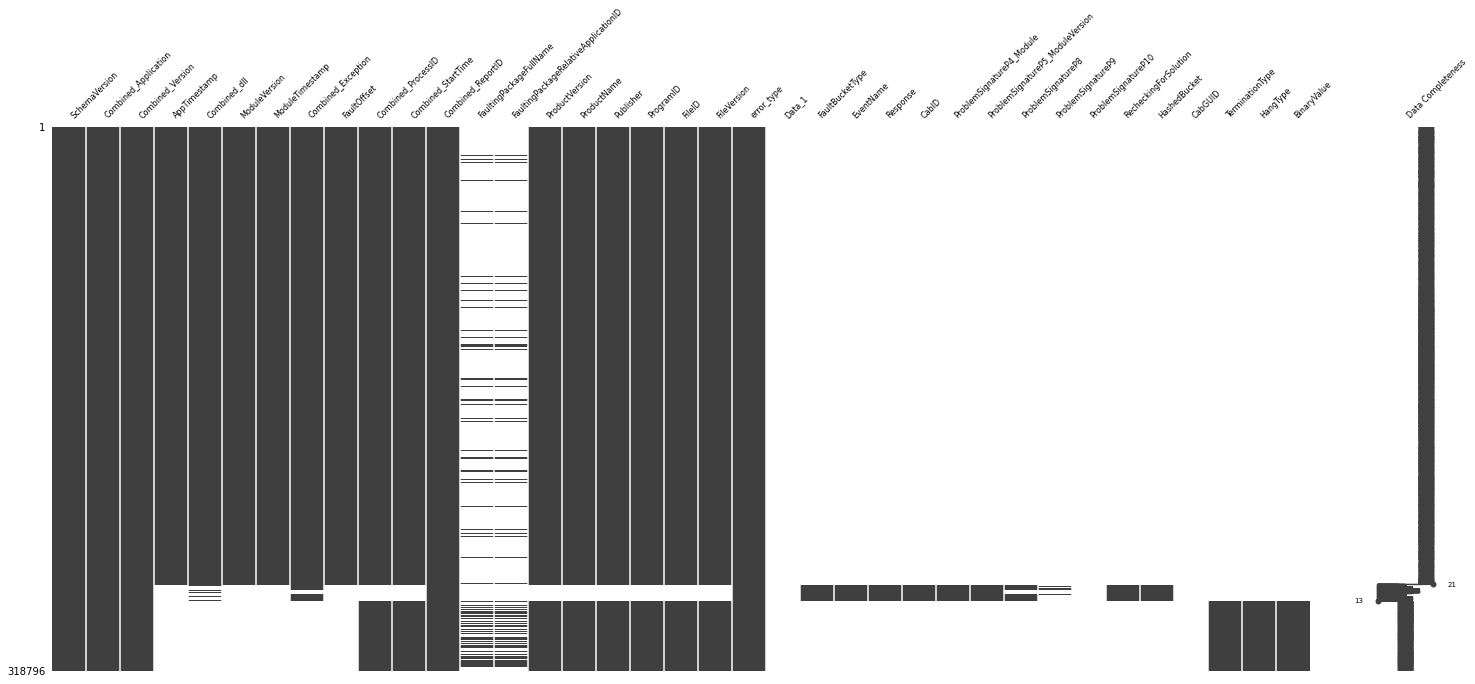

In [305]:
msno.matrix(events.iloc[:, 20:], labels=True, fontsize=8)


<a id='timeshift'></a>
# Shift TimeCreatedSystemTime to Central time to match INCs.


In [306]:
# Convert local time values to Central.
def convert_to_cst(df, utc_column_name, cst_column_name):

    # Make sure the UTC column is in datetime format
    df[utc_column_name] = pd.to_datetime(df[utc_column_name])

    # Convert to UTC timezone
    utc_timezone = pytz.timezone('UTC')
    df[utc_column_name] = df[utc_column_name].dt.tz_localize(utc_timezone)

    # Convert to Central Standard Time (CST) timezone
    cst_timezone = pytz.timezone('America/Chicago')
    df[cst_column_name] = df[utc_column_name].dt.tz_convert(cst_timezone)

    # Drop the original UTC column if desired (optional)
    # df.drop(columns=[utc_column_name], inplace=True)

    return df

events = convert_to_cst(events, utc_column_name='TimeCreatedSystemTime', cst_column_name='CreatedSystemTime_CST')

In [307]:
# Check all times are -05:00 or -06:00 from UTC (Daylight Savings Time).
events[['TimeCreatedSystemTime', 'CreatedSystemTime_CST']].sample(5)

,TimeCreatedSystemTime,CreatedSystemTime_CST
4385,2023-06-17 07:30:04.653000+00:00,2023-06-17 02:30:04.653000-05:00
9675,2023-01-26 17:23:28.153000+00:00,2023-01-26 11:23:28.153000-06:00
3209,2023-01-20 14:40:14.770000+00:00,2023-01-20 08:40:14.770000-06:00
6524,2023-03-31 12:12:50.360000+00:00,2023-03-31 07:12:50.360000-05:00
7747,2023-06-09 21:23:17.330000+00:00,2023-06-09 16:23:17.330000-05:00


In [308]:
events['CreatedSystemTime_CST_formatted'] = events['CreatedSystemTime_CST'].dt.strftime('%Y-%m-%d')


<a id="machines_events"></a>
# Join Machine data with Events data.


In [309]:
machines = pd.read_parquet('../do_not_commit/Datasets/Persist_System_DISC.pq')

In [310]:
# msno.matrix(incs, labels=True, fontsize=8)

In [311]:
machines['ClientItemKey'] = machines['ItemKey'].copy()

In [312]:
# Join machine name to events by internal date and item key.
machines_events = events.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'], how='left')

In [313]:
machines_events['TimeCreatedSystemTimeFormatted'] = machines_events['TimeCreatedSystemTime'].dt.strftime('%Y-%m-%d')

<AxesSubplot:>

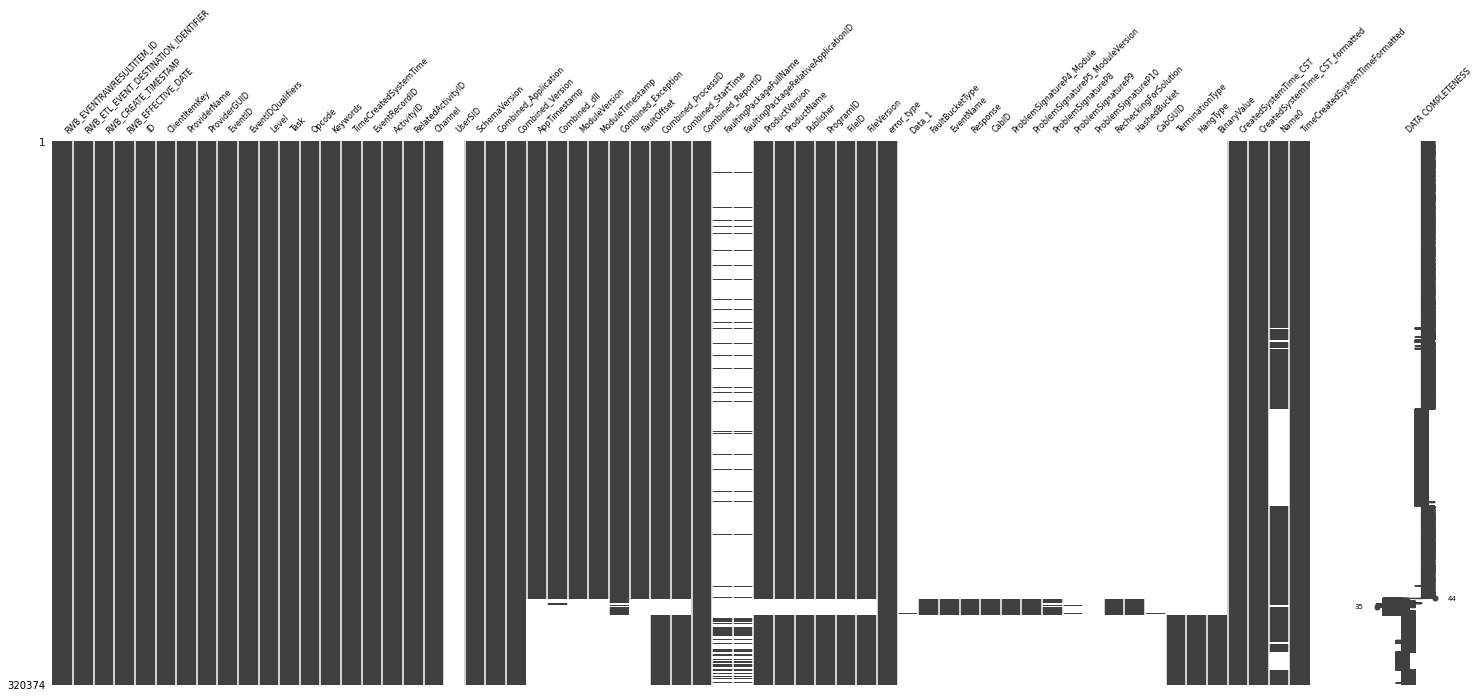

In [314]:
msno.matrix(machines_events, labels=True, fontsize=8)

In [315]:
machines_events[machines_events['error_type'].isin(['Application', 'Hang'])].sample(5)

,RWB_EVENTRAWRESULTITEM_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,ClientItemKey,ProviderName,ProviderGUID,EventID,EventIDQualifiers,...,RecheckingForSolution,HashedBucket,CabGUID,TerminationType,HangType,BinaryValue,CreatedSystemTime_CST,CreatedSystemTime_CST_formatted,Name0,TimeCreatedSystemTimeFormatted
150786,328211,812,2023-01-10 09:10:11 -06:00,2023-01-10,72057594080144106,16810072,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-07 20:23:33.590000-06:00,2023-01-07,LOU-L-U32695,2023-01-08
280248,4756602,5361,2023-04-07 08:46:24 -05:00,2023-04-07,72057594084649844,16808927,Application Hang,{00000000-0000-0000-0000-00000000000,1002,0,...,NaN,NaN,NaN,4294967295,Quiesce,510075006900650073006300650000000000,2023-04-06 09:53:37.167000-05:00,2023-04-06,MIL-L-U31636,2023-04-06
122579,1366440,1054,2023-01-27 09:09:14 -06:00,2023-01-27,72057594081204993,16811925,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-25 20:52:32.427000-06:00,2023-01-25,GRE-D-U14506,2023-01-26
299916,438054,818,2023-01-11 09:07:41 -06:00,2023-01-11,72057594080266704,16808281,Application Hang,{00000000-0000-0000-0000-00000000000,1002,0,...,NaN,NaN,NaN,4294967295,Top level window is idle,54006F00700020006C006500760065006C002000770069...,2023-01-10 07:42:46.333000-06:00,2023-01-10,ANN-L-U31211,2023-01-10
17770,4494759,4989,2023-04-01 08:46:09 -05:00,2023-04-01,72057594084385355,16812697,Application Error,{00000000-0000-0000-0000-00000000000,1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-31 17:16:42.333000-05:00,2023-03-31,MIL-L-U21568,2023-03-31



# Join INCs to machine + event.


In [316]:
# From blob storage:
# incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_Incident.csv', low_memory=False)
incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_INC_20230730.csv', low_memory=False)

In [317]:
# DateTime formatting.
incs['opened_at'] = pd.to_datetime(incs['opened_at'])
incs['opened_at_formatted'] = incs['opened_at'].dt.strftime('%Y-%m-%d')

In [318]:
# Join INCs to events on 1. Machine name, and 2. The event and the INC both occurred on the same day.
incs_merged = machines_events.merge(incs, left_on=['Name0', 'CreatedSystemTime_CST_formatted'], right_on=['configuration_item', 'opened_at_formatted'], how='left')

In [319]:
print(len(incs_merged))

320374


In [320]:
# Dropping columns with nothing in them.
incs_merged.dropna(axis=1, how='all', inplace=True)

In [321]:
# msno.matrix(incs_merged, labels=True, fontsize=7)

In [322]:
# Should be many more. Why only still 4,000?
print(len(incs), "INC rows originally")
print("Now", incs_merged['number'].notnull().sum())

6104 INC rows originally
Now 4083


In [323]:
incs_merged.sample(10)[[
    'error_type',
    # 'OSVersion',
    'Combined_Application',
    'Combined_dll',
    # 'FaultingPackageFullName',
    'ProductName',
    'category',
    'subcategory',
    'short_description_NER'
]]

,error_type,Combined_Application,Combined_dll,ProductName,category,subcategory,short_description_NER
126385,Application,powershell.exe,BIOSIntf.dll,Microsoft® Windows® Operating System,NaN,NaN,NaN
59585,Application,Acrobat.exe,fdsadobebridgeplugin.api_unloaded,Adobe Acrobat,NaN,NaN,NaN
267526,Application,powershell.exe,BIOSIntf.dll,Microsoft® Windows® Operating System,NaN,NaN,NaN
66243,Application,EXCEL.EXE,f_zyzmyruj.dll,Microsoft Office,NaN,NaN,NaN
211032,Application,ADPClientService.exe,ucrtbase.dll,Autodesk Windows Components,NaN,NaN,NaN
243445,Application,powershell.exe,BIOSIntf.dll,Microsoft® Windows® Operating System,NaN,NaN,NaN
141237,Application,IntelAudioService.exe,unknown,IntelAudioService,NaN,NaN,NaN
157607,Application,RuntimeBroker.exe,combase.dll,Microsoft® Windows® Operating System,NaN,NaN,NaN
233349,Application,powershell.exe,BIOSIntf.dll,Microsoft® Windows® Operating System,NaN,NaN,NaN
164707,Application,WINWORD.EXE,unknown,Microsoft Office,NaN,NaN,NaN


In [324]:
# INCs w/ multiple events assc. may attribute the event to the INC
# despite the event occurring *after* the INC was already filed.
incs_merged[incs_merged['number'] == 'INC0515837'][[
    'CreatedSystemTime_CST_formatted',
    'CreatedSystemTime_CST',
    'opened_at',
    'opened_at_formatted',
    'Name0',
    'configuration_item',
    'number',
    # 'FaultingApplicationName',
    # 'FaultingModuleName',
    'short_description_NER'
]]

,CreatedSystemTime_CST_formatted,CreatedSystemTime_CST,opened_at,opened_at_formatted,Name0,configuration_item,number,short_description_NER
74,2023-04-10,2023-04-10 08:28:18.740000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death
75,2023-04-10,2023-04-10 15:23:56.900000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death
269500,2023-04-10,2023-04-10 12:35:27.050000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death


In [325]:
incs_merged['CreatedSystemTime_CST']

0        2023-04-10 09:27:47.370000-05:00
1        2023-04-11 07:41:53.913000-05:00
2        2023-04-10 14:09:04.523000-05:00
3        2023-04-10 07:58:45.063000-05:00
4        2023-04-10 07:58:54.250000-05:00
                       ...               
320369   2023-04-10 15:37:12.363000-05:00
320370   2023-04-12 10:50:18.360000-05:00
320371   2023-04-11 17:09:58.767000-05:00
320372   2023-04-05 09:13:37.730000-05:00
320373   2023-04-13 08:16:49.137000-05:00
Name: CreatedSystemTime_CST, Length: 320374, dtype: datetime64[ns, America/Chicago]

In [326]:
incs_merged['opened_at_utc'] = incs_merged['opened_at'].dt.tz_localize('UTC')

In [327]:
incs_merged.loc[74, 'CreatedSystemTime_CST']

Timestamp('2023-04-10 08:28:18.740000-0500', tz='America/Chicago')

In [328]:
incs_merged.loc[74, 'opened_at_utc']

Timestamp('2023-04-10 11:20:00+0000', tz='UTC')

In [329]:
# This event happened after the INC was filed, at 13:28 UTC.
incs_merged.loc[74, 'CreatedSystemTime_CST'] - incs_merged.loc[74, 'opened_at_utc']

Timedelta('0 days 02:08:18.740000')

In [330]:
# Delete INCs across rows when the event occurs before the INC on the same day.
mask = incs_merged['CreatedSystemTime_CST'] >= incs_merged['opened_at_utc']
columns_to_set_none = incs.columns
incs_merged.loc[mask, columns_to_set_none] = None

In [331]:
# Looks like no 'CreatedSystemTime_CST value is > 'opened_at'.
incs_merged[incs_merged['number'].notnull()][['CreatedSystemTime_CST', 'opened_at', 'number']]

,CreatedSystemTime_CST,opened_at,number
502,2023-04-10 07:47:01.750000-05:00,2023-04-10 20:43:00,INC0516099
570,2023-04-10 07:29:33.643000-05:00,2023-04-10 17:39:00,INC0516019
571,2023-04-10 07:51:04.520000-05:00,2023-04-10 17:39:00,INC0516019
572,2023-04-10 10:59:19.490000-05:00,2023-04-10 17:39:00,INC0516019
635,2023-04-11 05:04:46.600000-05:00,2023-04-11 17:45:00,INC0516374
...,...,...,...
320201,2023-04-11 10:27:57.903000-05:00,2023-04-11 15:52:00,INC0516309
320202,2023-04-11 10:28:02.510000-05:00,2023-04-11 15:52:00,INC0516309
320346,2023-04-13 04:29:30.073000-05:00,2023-04-13 11:37:00,INC0516805
320347,2023-04-13 05:25:58.367000-05:00,2023-04-13 11:37:00,INC0516805


In [332]:
# Check to make sure. Positive = delete. Negative = keep.
(incs_merged['CreatedSystemTime_CST'] - incs_merged['opened_at_utc']).dropna()

74         0 days 02:08:18.740000
75         0 days 09:03:56.900000
502      -1 days +16:04:01.750000
570      -1 days +18:50:33.643000
571      -1 days +19:12:04.520000
                   ...           
320202   -1 days +23:36:02.510000
320346   -1 days +21:52:30.073000
320347   -1 days +22:48:58.367000
320348   -1 days +22:49:29.357000
320349     0 days 00:47:37.237000
Length: 4083, dtype: timedelta64[ns]

In [333]:
# Timedelta of -1 days (24h) + 16:04 = 8h 04m difference in true time.
incs_merged.loc[502, ['CreatedSystemTime_CST', 'opened_at_utc']]

CreatedSystemTime_CST    2023-04-10 07:47:01.750000-05:00
opened_at_utc                   2023-04-10 20:43:00+00:00
Name: 502, dtype: object


# Join Machines data with Boot data.


In [334]:
df_boot = pd.read_parquet('../do_not_commit/Datasets/BootEvents.parquet')
print(len(df_boot))

1593485


In [335]:
df_boot['error_type'] = 'Boot'

In [336]:
# What columns do all four event types have in common?
common_columns = reduce(np.intersect1d, (df_app.columns, df_boot.columns, df_hang.columns, df_win.columns))
common_columns

array(['ClientItemKey', 'ID', 'RWB_CREATE_TIMESTAMP',
       'RWB_EFFECTIVE_DATE', 'RWB_ETL_EVENT_DESTINATION_IDENTIFIER',
       'SchemaVersion', 'error_type'], dtype=object)

In [337]:
df_boot.rename(
    columns={
        'BootId':'BootID',
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'AppVersion':'Combined_Version',
        'ExceptionCode':'Combined_Exception',
        'ReportId':'ReportID'
    },
    inplace=True
)

In [338]:
# Needs to be a str to join later w/ 'opened_at_formatted'.
df_boot['BootID_formatted'] = df_boot['BootID'].dt.strftime('%Y-%m-%d')

In [339]:
# Join machine name to boot events, similar to other section.
machines_boot = df_boot.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'])


# Join INCs to machine + boot.


In [340]:
incs_boot = machines_boot.merge(incs, left_on=['Name0', 'BootID_formatted'], right_on=['configuration_item', 'opened_at_formatted'], how='left')

In [341]:
print(incs_boot['number'].notnull().sum(), "Boot INCs")

5069 Boot INCs


In [342]:
# Dropping columns with nothing in them.
incs_boot.dropna(axis=1, how='all', inplace=True)


#### How many multiple INCs were filed on the same day for a given machine?


In [343]:
grouped_counts = incs.groupby(['opened_at_formatted', 'configuration_item']).size()
print(grouped_counts[grouped_counts > 1].sum())
grouped_counts[grouped_counts > 1]

0


Series([], dtype: int64)


# Bring both DataFrames together.


In [344]:
incs_boot[incs_boot['number'].notnull()]

,RWB_EVENTBOOTRESULT_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,EventListID,ClientItemKey,GeneratedTime,UpdateDurationInMilliseconds,GPDurationInMilliseconds,...,is_server,short_description_NER,configuration_item,calling_user_id,opened_at_date,machine_user_test,opened_at_formatted,count,dup,group_index_orig
86,949656,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080687,3,16792948,2023-02-01 09:22:37.737,0,0,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
87,949657,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080688,3,16792948,2023-02-01 09:22:37.737,0,0,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
88,949659,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080690,3,16792948,2023-02-01 09:22:37.737,0,0,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
89,949655,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080686,3,16792948,2023-02-01 09:22:37.737,0,13514,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
90,949660,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080691,3,16792948,2023-02-01 09:22:37.737,0,11379,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845889,1484152,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043642172,3,16795890,2023-05-20 04:24:55.647,0,18555,...,0.0,Citrix VDA needed asap- CHE - D - U27461,CHE-D-U27461,12384.0,2023-05-19,CHE-D-U27461,2023-05-19,1.0,0.0,4362.0
845890,1484152,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043642172,3,16795890,2023-05-20 04:24:55.647,0,18555,...,0.0,Citrix VDA needed asap- CHE - D - U27461,CHE-D-U27461,12384.0,2023-05-19,CHE-D-U27461,2023-05-19,1.0,0.0,4362.0
847673,1485125,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043643145,3,16792903,2023-05-20 11:23:57.840,0,14226,...,0.0,missing teams install,CLM-D-U25402,78.0,2023-05-19,NaN,2023-05-19,1.0,0.0,4368.0
847674,1485125,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043643145,3,16792903,2023-05-20 11:23:57.840,0,14226,...,0.0,missing teams install,CLM-D-U25402,78.0,2023-05-19,NaN,2023-05-19,1.0,0.0,4368.0


In [345]:
df = pd.concat([incs_merged, incs_boot])
df.reset_index(inplace=True)

In [346]:
# Dropping columns with nothing in them.
df.dropna(axis=1, how='all', inplace=True)

In [347]:
# Drop all data for May 20th, 2023.
df = df[df['RWB_EFFECTIVE_DATE'] != '2023-05-20']

<AxesSubplot:>

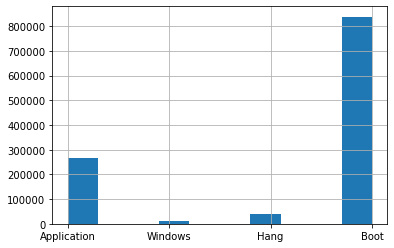

In [348]:
df['error_type'].hist()

In [349]:
df.dtypes

index                                     int64
RWB_EVENTRAWRESULTITEM_ID               float64
RWB_ETL_EVENT_DESTINATION_IDENTIFIER      int64
RWB_CREATE_TIMESTAMP                     object
RWB_EFFECTIVE_DATE                       object
                                         ...   
MachineName                              object
Reason                                   object
param5                                   object
ActionDescription                        object
BootID_formatted                         object
Length: 172, dtype: object

In [350]:
# How many boot events occurred after an INC was filed?
# df[df['error_type'] == 'Boot']['BootID'] - df[df['error_type'] == 'Boot']['opened_at_utc']

In [351]:
df.shape

(1155349, 172)

<AxesSubplot:>

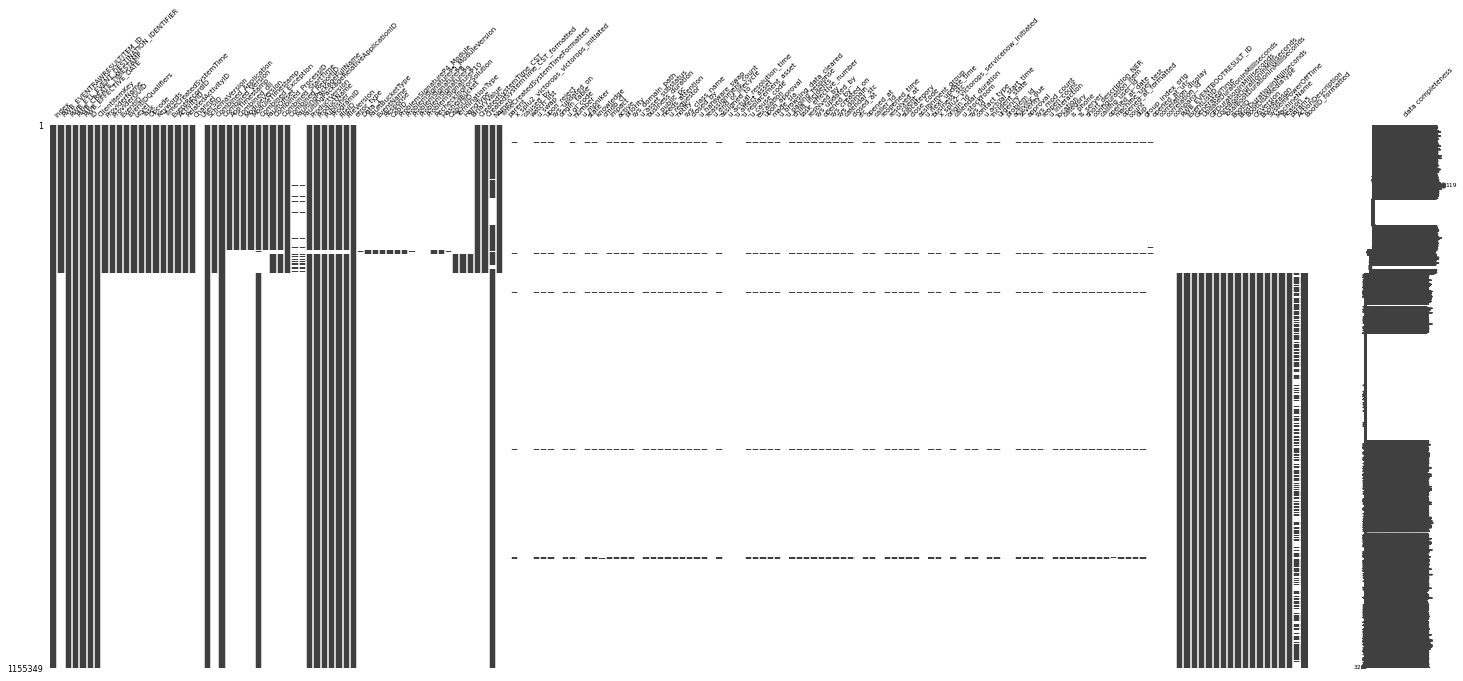

In [352]:
msno.matrix(df, labels=True, fontsize=7)


#### How many INCs contain direct reference to BSOD?


In [353]:
df['short_description_NER'].unique()

array([nan, None, 'headset not recognizing headset', ...,
       '  am trying to log into the principal website( Benefit Quick Link) via Workday and it says the site is down. But others on the team are able to get in. Seems to be only me.',
       'Laptop camera not working correctly',
       'Google Chrome icon on task bar is a blank square'], dtype=object)

In [354]:
# How many short descriptions talk about BSODs?
len(df.dropna(subset='short_description_NER')[df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")]['number'].unique())

53

<AxesSubplot:>

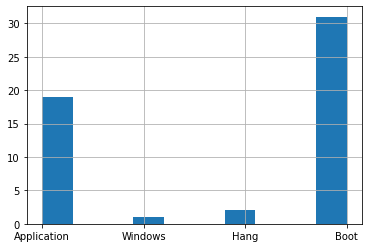

In [355]:
# What is the frequency of each error type for BSOD tickets?
df.dropna(subset='short_description_NER')[df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")].drop_duplicates('number', keep='first')['error_type'].hist()

In [359]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath"))].drop_duplicates('number', keep='first')[['error_type', 'Combined_Application', 'Combined_dll', 'Combined_Exception']]

,error_type,Combined_Application,Combined_dll,Combined_Exception
25428,Application,powershell.exe,BIOSIntf.dll,c0000005
46501,Application,powershell.exe,BIOSIntf.dll,c0000005
47697,Application,powershell.exe,BIOSIntf.dll,c0000005
51341,Application,OUTLOOK.EXE,ntdll.dll,c0000374
54403,Application,RtkAudUService64.exe,RtkAudUService64.exe,c0000005
64927,Application,powershell.exe,BIOSIntf.dll,c0000005
68205,Application,dwm.exe,HeatCore.dll,c0000409
75252,Application,powershell.exe,BIOSIntf.dll,c0000005
81591,Application,IntelAudioService.exe,ControlModule.dll,c0000005
83756,Application,powershell.exe,BIOSIntf.dll,c0000005


In [361]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Application')].drop_duplicates('number', keep='first')['Combined_Application']

/tmp/ipykernel_25356/1312422880.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Application')].drop_duplicates('number', keep='first')['Combined_Application']


25428                       powershell.exe
46501                       powershell.exe
47697                       powershell.exe
51341                          OUTLOOK.EXE
54403                 RtkAudUService64.exe
64927                       powershell.exe
68205                              dwm.exe
75252                       powershell.exe
81591                IntelAudioService.exe
83756                       powershell.exe
84440                       powershell.exe
89599                       WavesSvc64.exe
89952                       powershell.exe
93779     svchost.exe_BrokerInfrastructure
97864                       powershell.exe
108639                      powershell.exe
113451                      powershell.exe
145464                RtkAudUService64.exe
221248                      powershell.exe
Name: Combined_Application, dtype: object

In [362]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Boot')].drop_duplicates('number', keep='first')['short_description_NER']

/tmp/ipykernel_25356/4070623319.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Boot')].drop_duplicates('number', keep='first')['short_description_NER']


374952                              BSOD- No stop code error
415462                                                  BSOD
423709                                                  BSOD
426663                  Plugging in headphones prompted BSOD
677055     BSOD at Startup- Stop Code WHEA- uncorrectable...
687916     Received the blue screen of death <CARDINAL> t...
691703                                                  BSOD
719100                              Laptop BSOD'd 5/10/20223
729951     Laptop Overheating, Blue Screen Crashing- Unit...
735266     Repeated Blue Screen Error: Device did not sta...
748475     BSOD at Startup- Get stuck at Dell logo before...
753452                         Blue Screen Crashes on laptop
753575                   Laptop Blue Screening Every Morning
774293                                         BSOD- Startup
778512                                 Laptop BSOD on U30366
779379                BSOD- Device did not startup correctly
787205                  


#### What is the distribution of FaultApplicationName among INCs?


In [363]:
df_check = df[df['error_type'] == 'Application']

In [365]:
df_check['Combined_Application'].value_counts()

powershell.exe          69017
EXCEL.EXE               21941
Acrobat.exe             20938
WavesSvc64.exe          14684
RtkAudUService64.exe    13580
                        ...  
svchost.exe_UsoSvc          1
Upfc.exe                    1
RaptorExporter.exe          1
NWMSysDialog.exe            1
EikonBoxNet.exe             1
Name: Combined_Application, Length: 736, dtype: int64


#### What is the distribution of modules among INCs?


In [366]:
df_check['Combined_dll'].value_counts()

BIOSIntf.dll            68893
KERNELBASE.dll          42027
ntdll.dll               24195
WavesSvc64.exe          14631
RtkAudUService64.exe    13449
                        ...  
r_wrsfmkja.dll              1
w_wobvwihq.dll              1
m_omqxqggo.dll              1
u_wwxgcujv.dll              1
u_lwawedzn.dll              1
Name: Combined_dll, Length: 18061, dtype: int64


#### Which exception codes are most common among INCs?


In [367]:
df_check[['Combined_Application', 'Combined_Exception']].value_counts()

Combined_Application       Combined_Exception
powershell.exe             c0000005              68899
WavesSvc64.exe             c0000005              14663
RtkAudUService64.exe       c0000005              13466
Acrobat.exe                c0000005               9437
                           e06d7363               9315
                                                 ...  
SSFolderPrev.exe           c0000005                  1
SSHPdf2Jpg.exe             c0000094                  1
SSMS-Setup-ENU.exe         c00000fd                  1
Sage.NA.AT_AU.SysTray.exe  c000041d                  1
zt.exe                     c0000005                  1
Length: 1702, dtype: int64